## Initialization
Import relevant packages

In [1]:
import os
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import settree

## Create dataset
Create synthetic dataset of 2D point, following exp.1 in the paper (first quadrant). This dataset is comprised from sets of 2D points,
a positive set contains a single point from the first quadrant. A negative set is not containing points from the first quadrant.
We also configure a SetDataset object to be used in conjunction with SetTree. This object stores the sets in a convenient way.

In [2]:
# Data params
SET_SIZE = 5
ITEM_DIM = 2
N_TRAIN = 1000
N_TEST = 1000

np.random.seed(0)

x_train, y_train = settree.get_first_quarter_data(
    N_TRAIN, min_items_set=SET_SIZE, max_items_set=SET_SIZE + 1, dim=ITEM_DIM
)
x_test, y_test = settree.get_first_quarter_data(
    N_TEST, min_items_set=SET_SIZE, max_items_set=SET_SIZE + 1, dim=ITEM_DIM
)
ds_train = settree.SetDataset(records=x_train, is_init=True)
ds_test = settree.SetDataset(records=x_test, is_init=True)

print("Train dataset object: " + str(ds_train))
print("Test dataset object: " + str(ds_test))

Train dataset object: SetDataset(num_records=1000, num_features=2)
Test dataset object: SetDataset(num_records=1000, num_features=2)


Configure the desired set-compatible split criteria for SetTree.

In [3]:
list_of_operations = settree.OPERATIONS
print(settree.OPERATIONS)

[Op (min), Op (max), Op (sum), Op (mean), Op (sec_mom_mean), Op (harm_mean), Op (geo_mean)]


## Configure and train Set-Tree model

In [4]:
# Model params
ATTN_SET_LIMIT = 3
USE_ATTN_SET = True
USE_ATTN_SET_COMP = True
MAX_DEPTH = 6
SEED = 0

set_tree_model = settree.SetTree(
    classifier=True,
    criterion="entropy",
    splitter="sklearn",
    max_features=None,
    min_samples_split=2,
    operations=list_of_operations,
    use_attention_set=USE_ATTN_SET,
    use_attention_set_comp=USE_ATTN_SET_COMP,
    attention_set_limit=ATTN_SET_LIMIT,
    max_depth=MAX_DEPTH,
    min_samples_leaf=None,
    random_state=SEED,
)
set_tree_model.fit(ds_train, y_train)
set_tree_test_acc = (set_tree_model.predict(ds_test) == y_test).mean()
print("Set-Tree: Test accuracy: {:.4f}".format(set_tree_test_acc))

Set-Tree: Test accuracy: 0.9970


## Configure and train a Set-Tree Gradient Boosted Model

In [6]:
from sklearn.model_selection import train_test_split

train_idx, val_idx = train_test_split(
    np.arange(len(ds_train)), test_size=0.2, random_state=SEED
)

train_x = ds_train.get_subset(train_idx)
train_y = y_train[train_idx]
val_x = ds_train.get_subset(val_idx)
val_y = y_train[val_idx]

set_boost_model = settree.GradientBoostedSetTreeClassifier(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=2,
    use_attention_set=USE_ATTN_SET,
    use_attention_set_comp=USE_ATTN_SET_COMP,
    attention_set_limit=ATTN_SET_LIMIT,
    random_state=SEED,
    n_iter_no_change=1,
)

set_boost_model.fit(train_x, train_y)
set_boost_test_acc = (set_boost_model.predict(ds_test) == y_test).mean()
print("Set-Boost: Test accuracy: {:.4f}".format(set_boost_test_acc))

Set-Boost: Test accuracy: 0.9980


## Configure and train vanilla decision tree model

In [6]:
x_train_flat, x_test_flat = settree.flatten_datasets(
    ds_train, ds_test, list_of_operations
)
tree_model = DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=MAX_DEPTH,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=SEED,
)

tree_model.fit(x_train_flat, y_train)
tree_test_acc = (tree_model.predict(x_test_flat) == y_test).mean()
print("Vanilla decision tree: Test accuracy: {:.4f}".format(tree_test_acc))

Vanilla decision tree: Test accuracy: 0.6940


## Visualize Set-Tree
In order to plot the tree's structure please install pydotplus:
conda install -c anaconda pydotplus

The trained model has 4 nodes and 5 leafs


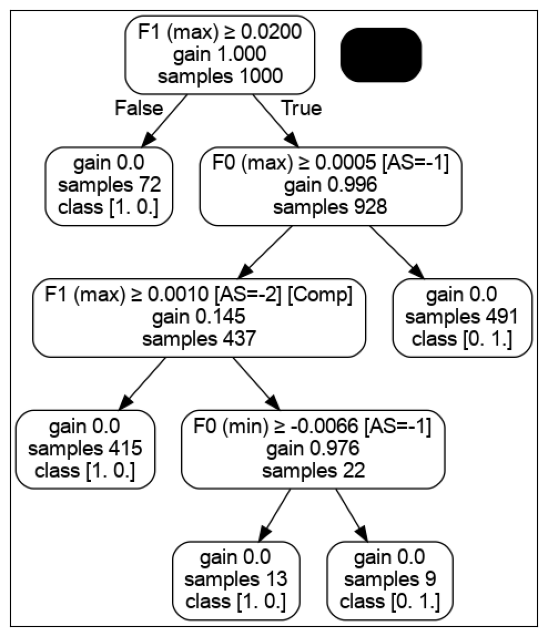

In [23]:
! pip install pydotplus
from exps.eval_utils.plotting import save_dt_plot
print('The trained model has {} nodes and {} leafs'.format(set_tree_model.n_nodes,
                                                           set_tree_model.n_leafs))
save_dt_plot(set_tree_model, features_list=None, dir='', file_name='dt_graph.jpg')
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(plt.imread(os.path.join(os.getcwd(), 'dt_graph.jpg')))
plt.xticks([]), plt.yticks([])
plt.show()

## Visualize the items importance

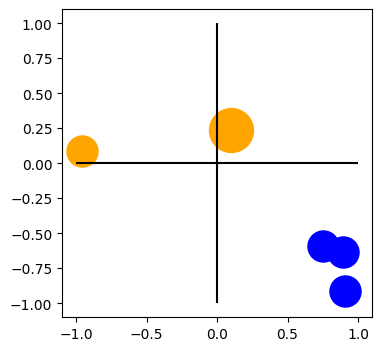

This is a visualization of a sample test set of points in 2D.
Each circle represents a point from the set of points and it's scale is proportional to its importance rank.
Legend:
Orange points: appear in the model's attention-sets
Blue points: don't appear in the model's attention-sets
The scale of the points is proportional to their relative importance, where larger circle means the point is more important in the decision process of the model.


In [24]:
SCALE = 1e3
N = 2
SAMPLE_LABEL = 1

test_indx = np.where(y_test == SAMPLE_LABEL)[0][N]
sample_record = x_test[test_indx]
point2rank = settree.get_item2rank_from_tree(
    set_tree_model, settree.SetDataset(records=[sample_record], is_init=True)
)

min_val = SCALE * 2 ** (-max(list(point2rank.values())))
fig = plt.figure(figsize=(4, 4), dpi=100, facecolor="w", edgecolor="k")
for i, point in enumerate(sample_record):
    if i in point2rank:
        plt.scatter(point[0], point[1], s=SCALE * 2 ** (-point2rank[i]), color="orange")
    else:
        plt.scatter(point[0], point[1], s=min_val, color="blue")
plt.hlines(0, -1, 1, colors="black")
plt.vlines(0, -1, 1, colors="black")
plt.show()

print(
    "This is a visualization of a sample test set of points in 2D.\nEach circle represents a point from the set of points and "
    "it's scale is proportional to its importance rank."
)
print(
    "Legend:\nOrange points: appear in the model's attention-sets\nBlue points: don't appear in the model's attention-sets\n"
    "The scale of the points is proportional to their relative importance, where larger circle means the point"
    " is more important in the decision process of the model."
)